In [1]:
using Pkg 
Pkg.activate(".");

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using RxInfer
using Random, LinearAlgebra, SpecialFunctions, Plots, StableRNGs, DomainSets, LaTeXStrings  
using Zygote, Optim, ForwardDiff
using MultivariateStats
using KernelFunctions, MAT, LoopVectorization

In [3]:
include("multivariateSGPnode.jl")
pgfplotsx()

Plots.PGFPlotsXBackend()

## Load data

In [4]:
my_file_data = open("3PhData/DataTrn.txt");
data = read(my_file_data,String);
data = parse.(Float64, split(chop(data; head=1, tail=1)));
data = [data[i:i+11] for i=1:12:length(data)];
;

In [5]:
# N = length(data)
N = 200
data = data[1:N];

In [10]:
my_file_label = open("3PhData/DataTrnLbls.txt");
label_data = read(my_file_label,String)
label_data = parse.(Float64, split(chop(label_data; head=1, tail=1)));
label_data = [label_data[i:i+2] for i=1:3:length(label_data)];

label_data = label_data[1:N];
;

In [11]:
label_text = Vector{Any}(undef,length(label_data))
for i=1:length(label_data)
    if label_data[i] == [1.0, 0.0, 0.0]
        label_text[i] = "Homogeneous"
    elseif label_data[i] == [0.0, 1.0, 0.0]
        label_text[i] = "Annular"
    else label_text[i] = "Stratified"
    end
end

pos_lb_homogeneous = findall((x) -> x=="Homogeneous",label_text)
pos_lb_annular = findall((x) -> x=="Annular",label_text)
pos_lb_stratified = findall((x) -> x=="Stratified",label_text)
;

In [12]:
D_out = length(data[1])
D_in = 2
;

In [13]:
# perform PCA
matrix_data = hcat(data...) ;
M = fit(PCA, matrix_data; maxoutdim=2)
mX = predict(M, matrix_data)
;

In [14]:
mean_X = [mX[:,i] for i=1:N];

## GPLVM model

In [15]:
@model function GPLVM(y,Xm, d_in, d_out, Kuu_big)
    
    v ~ MvNormalWeightedMeanPrecision(zeros(size(Kuu_big,1)), Kuu_big)
    
    for i=1:length(y)
        x[i] ~ MvNormalMeanCovariance(Xm[i], 100diageye(d_in))
        y[i] ~ GPTransition(x[i],v,1e2diageye(d_out)) where { dependencies = RequireMarginalFunctionalDependencies(in = MvNormalMeanCovariance(mean_X[i], diageye(d_in)),)}
    end
end
;

## Configure GP

In [41]:
Random.seed!(86)
M = 30
pos_Xu = randperm(N)[1:M]
Xu = mean_X[pos_Xu]
θ_optimal = [ 0.775, 0.225] #(optimal)
kernel_gp   =  0.1* with_lengthscale(SEKernel(),[0.475,0.775]) 
meanfunc = (x) -> 0.0
Kuu = kernelmatrix(kernel_gp,Xu,Xu) + 1e-12*I;
Kuu_inverse = inv(Kuu) + 1e-12*I;
C = diageye(D_out)  #coregionalization matrix 
;

In [42]:
@meta function GPLVM_meta(method,Xu,Kuu_inverse,C,kernel,cache)
    GPTransition() -> GPTransitionMeta(method,Xu,Kuu_inverse,C,kernel,cache)
end

gp_constraint = @constraints begin
    q(x,v) = q(x)q(v)
end

gp_initialization = @initialization begin
    q(v) = MvNormalWeightedMeanPrecision(zeros(size(kron(C,Kuu),1)), kron(C,Kuu))
end
;

In [43]:
niter =10

infer_result_gp = infer(
    model = GPLVM(d_in = D_in, d_out = D_out, Kuu_big = kron(C,Kuu),),
    iterations = niter,
    data = (y = data, Xm = mean_X,),
    initialization = gp_initialization,
    constraints = gp_constraint,
    meta = GPLVM_meta(srcubature(),Xu, Kuu_inverse,C,kernel_gp,GPCache()),
    returnvars = (x = KeepLast(),),
    free_energy = true,
    showprogress = true
) 

Progress: 100%|█████████████████████████████████████████| Time: 0:08:35


Inference results:
  Posteriors       | available for (x)
  Free Energy:     | Real[51399.6, 2088.19, 1546.21, 1345.33, 1236.77, 1165.58, 1118.58, 1082.95, 1057.42, 1037.38]


In [44]:
qx = infer_result_gp.posteriors[:x];
;

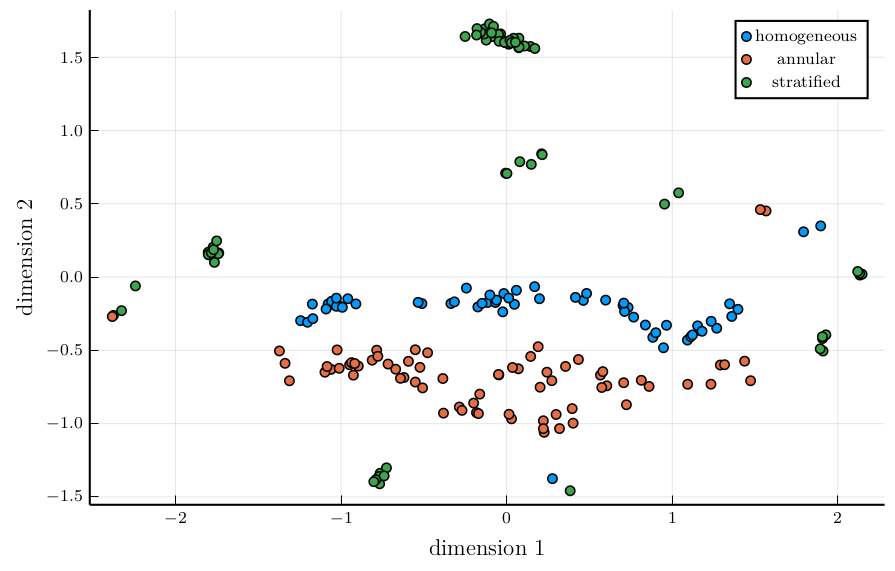

In [45]:
scatter(getindex.(mean.(qx),1)[pos_lb_homogeneous],getindex.(mean.(qx),2)[pos_lb_homogeneous],label = "homogeneous",markersize=3., legend=:topright)
scatter!(getindex.(mean.(qx),1)[pos_lb_annular],getindex.(mean.(qx),2)[pos_lb_annular],label = "annular",markersize=3.)
scatter!(getindex.(mean.(qx),1)[pos_lb_stratified],getindex.(mean.(qx),2)[pos_lb_stratified],label = "stratified",markersize=3.)
xlabel!("dimension 1")
ylabel!("dimension 2")

In [47]:
savefig("texfiles/GPLVM_SGPresult.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/GPLVM_SGPresult.svg"

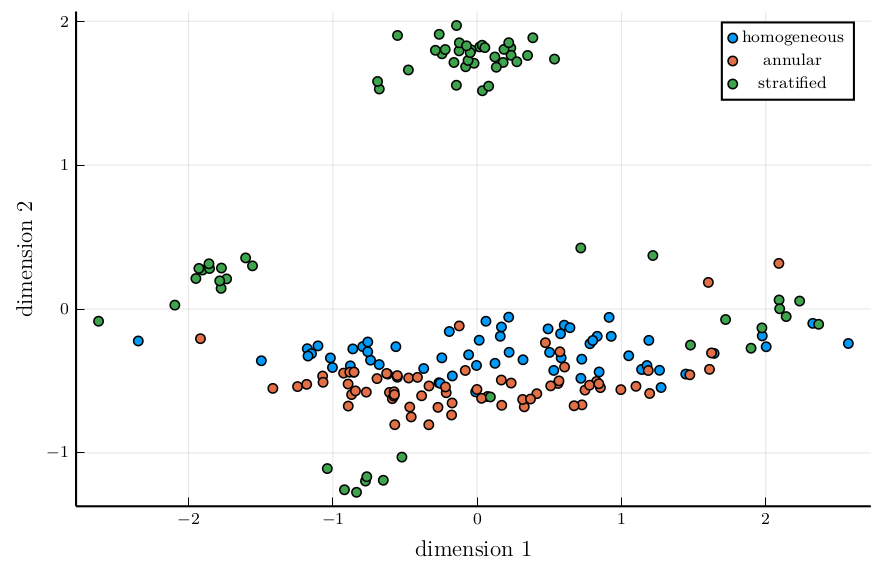

In [46]:
scatter(mX[1,pos_lb_homogeneous],mX[2,pos_lb_homogeneous],label = "homogeneous", markersize=3, legend=:topright)
scatter!(mX[1,pos_lb_annular],mX[2,pos_lb_annular],label = "annular",markersize=3)
scatter!(mX[1,pos_lb_stratified],mX[2,pos_lb_stratified],label = "stratified",markersize=3)
xlabel!("dimension 1")
ylabel!("dimension 2")

In [23]:
savefig("texfiles/GPLVM_PCAresult.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/GPLVM_PCAresult.svg"

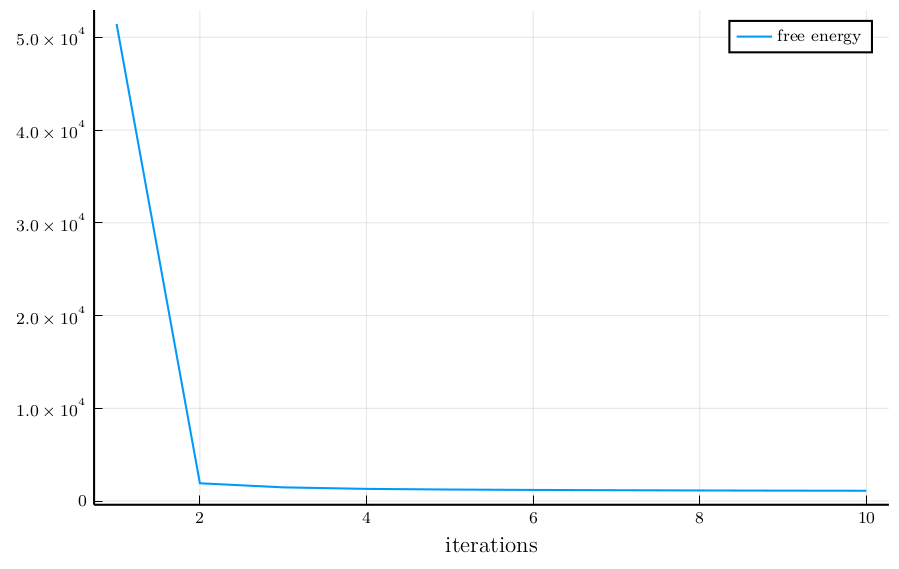

In [24]:
plot(infer_result_gp.free_energy, label="free energy", legend=:topright)
xlabel!("iterations")

In [25]:
savefig("texfiles/GPLVM_FE.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/GPLVM_FE.svg"

## Optimize

In [31]:
kernel_gp_param = (θ) -> 0.1*with_lengthscale(SEKernel(),[θ[1], θ[2]]); 
kernelmatrix_param = (θ) -> kernelmatrix(kernel_gp_param(θ),Xu,Xu);
function my_free_energy(θ)
    my_Kuu = kernelmatrix_param(θ)
    my_Kuu_inverse = inv(my_Kuu)
    my_kernel = kernel_gp_param(θ)

    init = @initialization begin
        q(v) = MvNormalWeightedMeanPrecision(zeros(size(kron(C,my_Kuu),1)), kron(C,my_Kuu))
    end

    infer_result = infer(
        model = GPLVM(d_in = D_in, d_out = D_out, Kuu_big = kron(C,my_Kuu),),
        iterations = 6,
        data = (y = data, Xm = mean_X,),
        initialization = init,
        constraints = gp_constraint,
        meta = GPLVM_meta(srcubature(),Xu, my_Kuu_inverse,C,my_kernel,GPCache()),
        free_energy = true
    ) 
    @show θ
    return infer_result.free_energy[end]
end

function learn_params(θ,iter)
    res = optimize((x) -> my_free_energy(x), θ, NelderMead(),Optim.Options(iterations=iter))
    return res.minimizer
end

learn_params (generic function with 1 method)

In [39]:
#take ~30min
θ_init = [0.3 , 0.5] # [l1,l2]
θ_optimal= learn_params(θ_init,1)

θ = [0.3, 0.5]
θ = [0.475, 0.5]
θ = [0.3, 0.775]
θ = [0.4749999999999999, 0.7749999999999999]
θ = [0.5624999999999999, 0.9124999999999999]
θ = [0.475, 0.6375]


2-element Vector{Float64}:
 0.4749999999999999
 0.7749999999999999